In [1]:
using Kinbiont
using Plots
using StatsBase
using AbstractTrees
using MLJDecisionTreeInterface
using TreeRecipe
using DecisionTree
using Distributions
using Random

In this example, we will use Kinbiont to generate data about a single species that is exposed to different antibiotics, both alone and in different combinations.
We generate a simple function that modifies the growth rate of the species according to the antibiotics present in the media. We suppose that the user repeats the experiment, fits the data, and finally applies a decision tree algorithm using the antibiotics present in the media as features and the growth rate of the model as the quantity to predict.
We show how we can decompose the effect of the antibiotics on the kinetics.

In [2]:
# We initialize the array for the results
results_fit = Any

Any

We initialize the model, the guess, and the bounds to fit

In [3]:
ODE_models = "baranyi_richards"

"baranyi_richards"

In [4]:
ub_1 = [0.2, 5.1, 500.0, 5.0]
lb_1 = [0.0001, 0.2, 0.00, 0.2]
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2

4-element Vector{Float64}:
   0.10005000000000001
   2.65
 250.0
   2.6

We use the following rules to modify the growth rate of the species according to the antibiotics present in the media

In [5]:
function transform_abx_vector(input_vector::Vector, mu::Float64)
    
    # Define concentration mapping rules
    concentration_map = Dict(
        (1, 0, 0) => 1.0 ,    # abx_1 -> μ
        (0, 1, 0) => 0.5 ,    # abx_2 -> 0.5μ
        (0, 0, 1) => 0.3 ,    # abx_3 -> 0.3μ
        (1, 1, 0) => 0.0 ,    # abx_1 + abx_2 -> 0μ
        (1, 0, 1) => 0.3 ,    # abx_1 + abx_3 -> 0.3μ
        (0, 1, 1) => 0.0 ,    # abx_2 + abx_3 -> 0μ
        (1, 1, 1) => 0.0,     # abx_1 + abx_2 + abx_3 -> 0.0μ
        (0, 0, 0) => 1.0      # No antibiotics -> 1.0μ
    )
    
    mu_correct = concentration_map[Tuple(input_vector[2:end])] * mu   # Default to 0μ if not found
    return mu_correct
end

transform_abx_vector (generic function with 1 method)

In [6]:
# Generating the random matrix of the features
# Define the dimensions of the matrix
cols = 3
n_experiment = 100

100

In [7]:
# Generate a random matrix with 0s and 1s (antibiotic not present or present)
random_matrix = rand(0:1, n_experiment, cols)
labels = string.(1:1:n_experiment)
random_matrix = hcat(labels, random_matrix)
random_matrix

100×4 Matrix{Any}:
 "1"    1  1  0
 "2"    0  1  1
 "3"    0  1  1
 "4"    1  1  1
 "5"    0  1  0
 "6"    0  0  1
 "7"    0  0  1
 "8"    0  1  1
 "9"    0  1  0
 "10"   0  0  0
 "11"   1  0  1
 "12"   0  0  1
 "13"   0  1  0
 ⋮            
 "89"   1  0  1
 "90"   0  0  1
 "91"   1  1  0
 "92"   0  1  0
 "93"   1  0  1
 "94"   0  1  1
 "95"   0  1  1
 "96"   1  0  0
 "97"   1  1  1
 "98"   1  0  0
 "99"   0  0  0
 "100"  0  1  0

In [8]:
# Defining the parameter values for the simulation 
p_sim = [0.05, 1.0, 50.0, 1.0]
psim_1_0 = p_sim[1]
p1_array = [transform_abx_vector(random_matrix[f, :], psim_1_0) for f in 1:size(random_matrix)[1]]

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.025
 0.015
 0.015
 0.0
 0.025
 0.05
 0.015
 0.015
 0.025
 ⋮
 0.015
 0.015
 0.0
 0.025
 0.015
 0.0
 0.0
 0.05
 0.0
 0.05
 0.05
 0.025

In [9]:
t_min = 0.0
t_max = 800.0
n_start = [0.1]
delta_t = 10.0
noise_value = 0.03

0.03

In [11]:
plot(0, 0)
for f in 1:size(random_matrix)[1]

    # Changing the growth rate given the antibiotics present in the media
    p_sim[1] = transform_abx_vector(random_matrix[f, :], psim_1_0)

    # Calling the simulation function
    sim = Kinbiont.ODE_sim("baranyi_richards", n_start, t_min, t_max, delta_t, p_sim)

    # Adding uniform random noise
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(sim.t))

    data_t = reduce(hcat, sim.t)
    data_o = reduce(hcat, sim.u)
    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform
    # Plotting scatterplot of data with noise

    #display(Plots.scatter!(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))
    
    # Fit
    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(random_matrix[f, 1]),
        "test_ODE",
        "baranyi_richards",
        p1_guess;
        lb=lb_1,
        ub=ub_1
    )
    
    # Plot fit
    #display(Plots.plot!(results_ODE_fit[4], results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    # Storing results
    if f == 1
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end

In [12]:
# Parameters of the decision tree
n_folds = 10
depth = -1 

-1

In [13]:
# Set random seed for reproducibility
seed = Random.seed!(1234)

TaskLocalRNG()

In [14]:
# Generating feature matrix
# The first column is the label as a string of the feature values we used for fitting
feature_matrix = vcat(["label" "abx_1" "abx_2" "abx_3"], random_matrix)
feature_names = ["abx_1", "abx_2", "abx_3"]

3-element Vector{String}:
 "abx_1"
 "abx_2"
 "abx_3"

In [15]:
# Decision tree regression between the antibiotics present in the media and the growth rate of the species
dt_gr = Kinbiont.downstream_decision_tree_regression(results_fit,
        feature_matrix,
        4; # Row to learn
        do_pruning=false,
        verbose=true,
        do_cross_validation=true,
        max_depth=depth,
        n_folds_cv=n_folds,
        seed=seed
    )


Fold 1
Mean Squared Error:     0.0001385296127275327
Correlation Coeff:      0.890363731471361
Coeff of Determination: 0.2848148444326617

Fold 2
Mean Squared Error:     0.000224168446345212
Correlation Coeff:      0.8515344277485081
Coeff of Determination: 0.7099736291646502

Fold 3
Mean Squared Error:     8.251141962880859e-5
Correlation Coeff:      0.8960873081913677
Coeff of Determination: 0.7578051411243913

Fold 4
Mean Squared Error:     0.0003422503083637762
Correlation Coeff:      0.7757378634708173
Coeff of Determination: 0.5933945770137091

Fold 5
Mean Squared Error:     0.00014872082957923162
Correlation Coeff:      0.8795143023256199
Coeff of Determination: 0.7050664533731681

Fold 6
Mean Squared Error:     0.0003097659969321413
Correlation Coeff:      0.7805997632658089
Coeff of Determination: 0.38675678316494333

Fold 7
Mean Squared Error:     0.0004049298260094329
Correlation Coeff:      0.9392580346181129
Coeff of Determination: 0.7304345545456334

Fold 8
Mean Squared 

(Decision Tree
Leaves: 8
Depth:  3, [7.706885718533157e-5, 0.0002410470546764815, 0.00024389151527652204], [4.0, 2.0, 1.0], [0.2848148444326617, 0.7099736291646502, 0.7578051411243913, 0.5933945770137091, 0.7050664533731681, 0.38675678316494333, 0.7304345545456334, 0.7157516249668262, 0.7923612910802829, 0.8370028158970084], Any["values" 1.0 … 8.0 8.0; "cluster" 0.031423093015979564 … 0.0001000000000000134 0.00018522639059403618])

In [16]:
# Wrap the decision tree model for visualization
wt = DecisionTree.wrap(dt_gr[1], (featurenames = feature_names,))

abx_3 < 0.5
├─ abx_2 < 0.5
│  ├─ abx_1 < 0.5
│  │  ├─ 0.05925955251664342 (0/9)
│  │  └─ 0.06054839237549032 (0/15)
│  └─ abx_1 < 0.5
│     ├─ 0.033886428603836435 (0/16)
│     └─ 0.00039380078741913454 (0/12)
└─ abx_2 < 0.5
   ├─ abx_1 < 0.5
   │  ├─ 0.016562111764526325 (0/12)
   │  └─ 0.015495525584185238 (0/8)
   └─ abx_1 < 0.5
      ├─ 0.00048503124551786545 (0/12)
      └─ 0.00040911127255892756 (0/16)


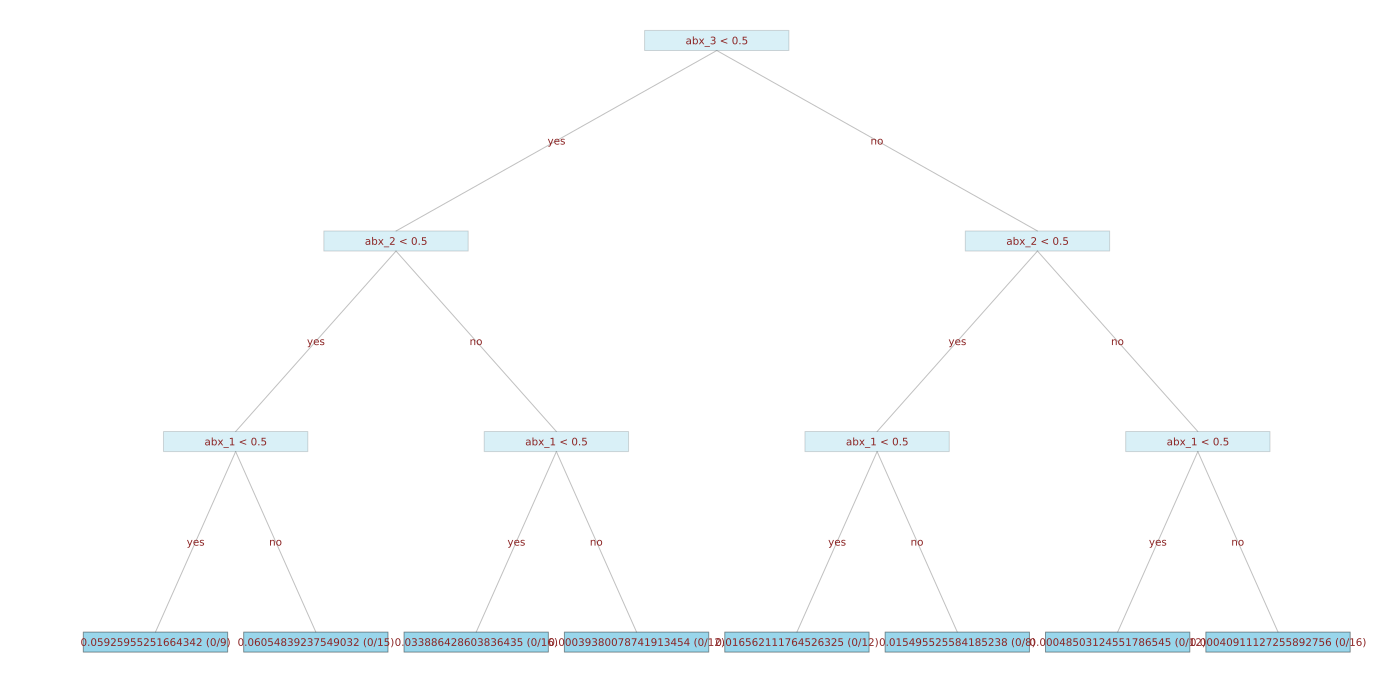

In [17]:
# Plot the decision tree
p2 = Plots.plot(wt, 0.9, 0.2; size=(1400, 700), connect_labels=["yes", "no"])